# Test Script For Loading Rosetta Radar
Julian Spergel & Isabel Cordero
<br> Created: 04-27-2021
<br> Modified: 05-07-2021
<br> updated for pangeo and GCS by DFP on 10-Jun-2021

## Load in required packages

In [1]:
import scipy.io
import os
import pandas as pd
import numpy as np
import xarray as xr
import gcsfs
import json
import matplotlib.pyplot as plt
import numpy.matlib
from glob import glob

import gcsfs
from tqdm import tqdm
import fsspec

xr.set_options(display_style="html");

In [2]:
## A chunk of code to start dask cluster
from dask.distributed import Client, progress
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
if gateway.list_clusters():
    cluster_name = gateway.list_clusters()[0].name
    cluster = gateway.connect(cluster_name)
    print(f"\nConnecting to pre-existing cluster with {len(cluster.scheduler_info['workers'])} workers.")
else:
    cluster = gateway.new_cluster() 
    cluster.adapt(minimum=4, maximum=12)
    print("\nStarting up and connecting to new cluster.")

cluster
# cluster.scheduler_info


Starting up and connecting to new cluster.


In [4]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.ec7805d21b1d466c92889ef9244f666d Dashboard: /services/dask-gateway/clusters/prod.ec7805d21b1d466c92889ef9244f666d/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load in SIR .mat file
Path is defined in order to show what directory we are working within. This should be a /decimated/mat/ path.
<br> The sirFile variable is defined with the SciPy loadmat(MATFILE)function + matfile:

In [5]:
gcsdir = 'gs://ldeo-glaciology'
datadir = 'ROSETTA'
instrument = 'SIR'

filepattern = 'RS02_L870_20161129_031207_level1a_SIR_*.mat'
pattern = os.path.join(gcsdir, datadir, instrument, filepattern)
print(pattern)



gs://ldeo-glaciology/ROSETTA/SIR/RS02_L870_20161129_031207_level1a_SIR_*.mat


In [6]:
# Path = '/trunk/icepod/antarctica/20162017/radar/sir/fft/stack04/lines/L870/decimated/mat/';
# sirFile = scipy.io.loadmat('RS02_L870_20161129_031207_level1a_SIR_176.mat')

In [7]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

In [8]:
infiles = fs.glob(pattern)
print(f"Total of {len(infiles)} SIR files.\n")
print(infiles[0])

Total of 1 SIR files.

ldeo-glaciology/ROSETTA/SIR/RS02_L870_20161129_031207_level1a_SIR_176.mat


In [9]:
openfile = fs.open(f'gs://{infiles[0]}', mode='rb') 
mat = scipy.io.loadmat(openfile)

The SciPy function loadmat seems to read .mat files as a "dictionary".
<br> Call the file to read the variables and double check the file type and etc. (not needed in final script likely)

In [10]:
# mat

The following is a pandas function that reads "dictionary" type files.
<br>    This is broken because "not all arrays are the same length/size:

In [11]:
# pd.DataFrame.from_dict(mat)

Read Data variable to determine size/structure (this isn't needed in final script either)

In [12]:
# mat['Data']

#### Define variables needed for rendering

In [13]:
Data = mat['Data']
Lat = mat['Latitude']
Lon = mat['Longitude']
Elev = mat['Elevation']
Time = mat['Time']
Surf = mat['Surface']
UTC_time = mat['UTC_time']

In [14]:
print(Data.shape)
print(Lat.shape)
print(Lon.shape)
print(Elev.shape)
print(Time.shape)
print(Surf.shape)
print(UTC_time.shape)

(14497, 4687)
(1, 4687)
(1, 4687)
(1, 4687)
(14497, 1)
(1, 4687)
(1, 4687)


Transpose Time variable from column to row:

In [15]:
np.diff(Time)

array([], shape=(14497, 0), dtype=float64)

## calculate/clip air above surface of ice:

#### Matlab example:
pixelElev = repmat(Elevation - .5*cAir*Surface,[size(Time,1),1]) - .5*cIce*(repmat(Time,[size(Surface,1),1]) - Surface);
<br>repmat(a, m, n)
<br>np.tile(a, (m, n))

In [16]:
cAir = 299792458;   # m/s
cIce = 1.68e8;      # m/s

aboveSurf = Elev - (.5*cAir)*(Surf)
# np.matlib.repmat(Time,[(np.shape(Surf),1),1]) - Surf
newTime = np.tile(Time,(1,Surf.size))
# belowSurf = (newTime - Surf)*(cIce*0.5)
belowSurf = newTime*(cIce*0.5)
Elevcorr = (aboveSurf - belowSurf)*1
# Time

In [17]:
print(Elevcorr.shape)
print(np.std(Elevcorr))

(14497, 4687)
223.91136815658064


-773.9913543296427
0.0


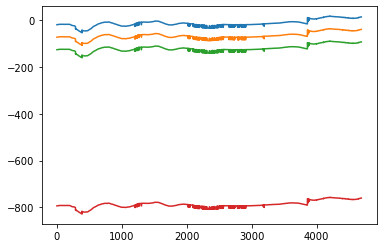

In [18]:
# plt.plot(aboveSurf[0,...])

plt.plot(Elevcorr[0,...])
plt.plot(Elevcorr[1000,...])
plt.plot(Elevcorr[2000,...])
plt.plot(Elevcorr[-1,...])
print(np.mean(Elevcorr[-1,...]-Elevcorr[0,...]))
print(np.std(Elevcorr[-1,...]-Elevcorr[0,...]))

## TWTT

In [19]:
data32 = np.float32(20*np.log10(np.abs(Data)))

In [42]:
da = xr.DataArray(
    data = data32,
#     data = 20*np.log10(np.abs(Data)),
    dims = ["time","x"],
    coords = dict(
        lon = (["x"], Lon[0]),
        lat = (["x"], Lat[0]),
        time = (["time"],Time.transpose()[0]),
#         elev = (["elev"],Elevcorr.transpose()[0]),
        
    ),
)


Calling "da" shows data array.

In [21]:
da.dtype

dtype('float32')

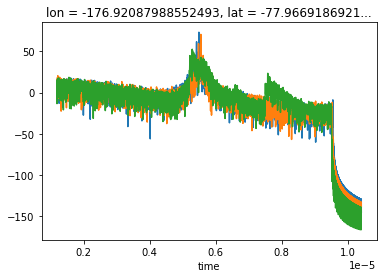

In [22]:
da.isel(x=0).plot()
da.isel(x=1000).plot()
da.isel(x=4000).plot()

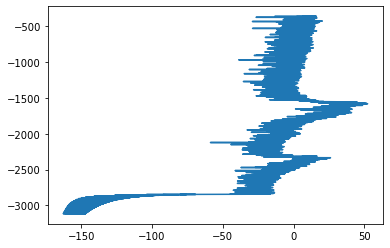

In [23]:
plt.plot(da.isel(x=-1), -da.time*2.998e+8)

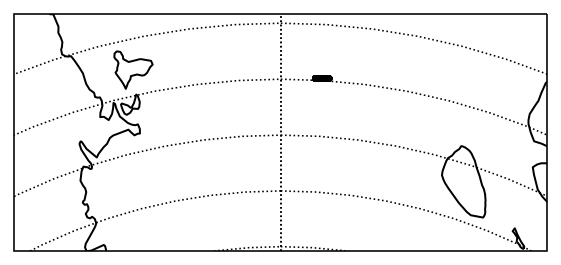

In [24]:
## THIS NEEDS cartopy 0.18 but can't install it for some reason...

import shapely.geometry as sgeom
import cartopy.crs as ccrs


box = sgeom.box(minx=160, maxx=200, miny=-76, maxy=-80.5)
x0, y0, x1, y1 = box.bounds
myproj = ccrs.SouthPolarStereo(central_longitude=180)
# myproj = ccrs.Orthographic()

plt.figure(figsize=(4, 5), facecolor='white', dpi=144)
ax = plt.axes(projection=myproj)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())  
ax.coastlines('50m')
# ax.stock_img()

# pcm1 = ax.pcolormesh(ds.lon, ds.lat, ds['SH'].mean(dim='time'),\
#                     vmin=-30, vmax=30,\
#                     transform=ccrs.PlateCarree())#, cmap=plt.get_cmap("BuPu")
## Alternative
# kwargs = dict(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree())
# pcm1 = ds['SH'].mean(dim='time').plot.contourf(
#     levels=31, robust=True,  **kwargs)

ax.plot(da.lon, da.lat, 'ko', markersize=2, transform=ccrs.PlateCarree())

ax.gridlines(color="black", linestyle="dotted")
# plt.suptitle('LH')
plt.tight_layout()
# plt.savefig('figs/mapplot_TNB_Fsfc_mean.png')
plt.show()

In [46]:
ds = da.to_dataset(name='twtt').chunk(chunks={'x':1000})
ds.twtt

<xarray.DataArray 'twtt' (time: 14497, x: 4687)>
dask.array<xarray-twtt, shape=(14497, 4687), dtype=float32, chunksize=(14497, 1000), chunktype=numpy.ndarray>
Coordinates:
    lon      (x) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat      (x) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * time     (time) float64 1.191e-06 1.191e-06 1.192e-06 ... 1.04e-05 1.04e-05
Dimensions without coordinates: x

In [47]:
ds.twtt.mean().compute()

<xarray.DataArray 'twtt' ()>
array(-15.026488, dtype=float32)

Plots "da" radargram.
<br> vmin and vmax change colors/resolution of image.

In [27]:
# plt.pcolormesh(da)

In [48]:
# da.loc[:,-1500:-1]
# da.sel(x=slice(3000, 4686))
# da.sel(x=[3000, 4686])

ds.sel(time=slice(0.4e-05,1.0e-05))

<xarray.Dataset>
Dimensions:  (time: 9440, x: 4687)
Coordinates:
    lon      (x) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat      (x) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * time     (time) float64 4e-06 4.001e-06 4.001e-06 ... 9.999e-06 1e-05
Dimensions without coordinates: x
Data variables:
    twtt     (time, x) float32 dask.array<chunksize=(9440, 1000), meta=np.ndarray>

In [49]:
ds_subset = ds.sel(x=slice(3000, 4686), time=slice(0.4e-05,1.0e-05)).compute()

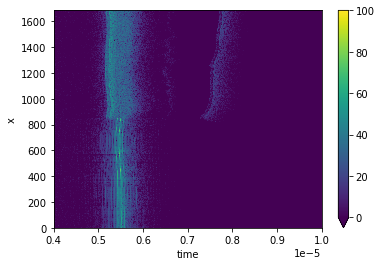

In [36]:
ds_subset.plot(x='time', 
               vmin = 0, vmax = 100,
#                cmap='Grays_r',
              )

# da.plot(vmin = 0, vmax = 100)
# da.plot()

### Push to google bucket

In [51]:
outdir = os.path.join(gcsdir, datadir, instrument, 'zarr/')

# fs.glob(outdir)
fs.ls(outdir)

['ldeo-glaciology/ROSETTA/SIR/zarr/']

In [52]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'RS02_L870_20161129_SIR.zarr', mode='ab',
                            token=token)

In [53]:
%%time
ds_subset.to_zarr(amps_mapper, mode='w');

CPU times: user 1.33 s, sys: 104 ms, total: 1.43 s
Wall time: 4.48 s


### Okay, now make a ELEVCORR dataset

and append to existing zarr?

`>> ds2.to_zarr("path/to/directory.zarr", append_dim="t")`

In [60]:
da = xr.DataArray(
    data = Elevcorr,
#     data = 20*np.log10(np.abs(Data)),
    dims = ["time","x"],
    coords = dict(
        lon = (["x"], Lon[0]),
        lat = (["x"], Lat[0]),
        time = (["time"],Time.transpose()[0]),
#         elev = (["elev"],Elevcorr.transpose()[0]),
        
    ),
)
ds = da.to_dataset(name='Elevcorr').chunk(chunks={'x':1000})
ds_subset = ds.sel(x=slice(3000, 4686), time=slice(0.4e-05,1.0e-05)).compute()

In [61]:
ds_subset.to_zarr(amps_mapper, mode='a')

## Read that SIR Zarr we just wrote

In [63]:
ds_gcs = xr.open_zarr(amps_mapper)

In [64]:
ds_gcs
#ds_gcs['twtt']

<xarray.Dataset>
Dimensions:   (time: 9440, x: 1686)
Coordinates:
    lat       (x) float64 dask.array<chunksize=(1686,), meta=np.ndarray>
    lon       (x) float64 dask.array<chunksize=(1686,), meta=np.ndarray>
  * time      (time) float64 4e-06 4.001e-06 4.001e-06 ... 9.999e-06 1e-05
Dimensions without coordinates: x
Data variables:
    Elevcorr  (time, x) float64 dask.array<chunksize=(590, 211), meta=np.ndarray>
    twtt      (time, x) float32 dask.array<chunksize=(1180, 211), meta=np.ndarray>

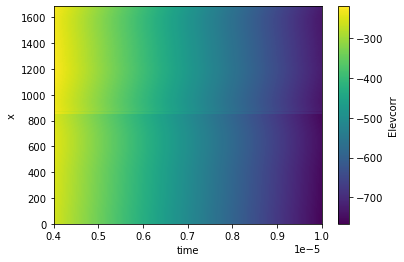

In [66]:
ds_gcs['Elevcorr'].plot(x='time', 
#               vmin = 0, vmax = 100,
#                cmap='Grays_r',
              )

# Addendum

one way (from julian?)

In [ ]:
# gcs = gcsfs.GCSFileSystem()
# with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
#     token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)
# #EXPORT THE DATA TO THE  GOOGLE BUCKET
# mapper = gcs.get_mapper('gs://ldeo-glaciology/Isabel/test1/') #choose where to put it
# da.to_zarr(mapper, mode='w');

another way

In [ ]:
# #EXPORT A DATASET 
# measures_exported = measures #a dataset that is ready to be  exported
# gcs = gcsfs.GCSFileSystem()
# with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
#     token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)
# #EXPORT THE DATA TO THE  GOOGLE BUCKET
# mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/') #choose where to put it
# measures.to_zarr(mapper, mode='w');
# #IMPORT THE FILES TOU JUST SENT TO THE BUCKET
# mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')
# measures_IMPORTED = xr.open_zarr(mapper,overwrite_encoded_chunks=True)

# DEBUG section: Removing air above surface to plot entire ice shelf section
Below are working sections in order to debug the above "final" code.

In [ ]:
# Matlab example:
# pixelElev = repmat(Elevation - .5*cAir*Surface,[size(Time,1),1]) - .5*cIce*(repmat(Time,[size(Surface,1),1]) - Surface);
# repmat(a, m, n)
# np.tile(a, (m, n))
cAir = 299792458;   # m/s
cIce = 1.68e8;      # m/s

aboveSurf = Elev - (.5*cAir)*(Surf)
# np.matlib.repmat(Time,[(np.shape(Surf),1),1]) - Surf
aboveSurf.shape
newTime = np.tile(Time,(1,Surf.size))
belowSurf = (newTime - Surf)*(cIce*0.5)
Elevcorr = aboveSurf - belowSurf
newElev = Elevcorr[:,0]
newTime.shape
# newElev = Elevcorr{1}
# Time.transpose() - np.reshape(Surf,Time.shape)
# Time - (np.pad(Surf,Time.shape,mode='empty', **0))
# (array, pad_width, mode='constant', **kwargs)
# newElev = [Elev.transpose(((Elev - .5*cAir*Surf),Surf)) - .5*cIce*(Time - Surf.transpose((1,Time)))]

In [ ]:
# adjustSurf = Surf.transpose()
# Time.transpose()
# adjustTime = Time.squeeze(4687,1)
# np.reshape(Surf,(1,4687))
# np.pad(Surf,(,4687),)
time2 = Time.transpose()
surf2 = np.matlib.repmat(Surf,np.shape(time2),1)
# surf2.shape

# np.matlib.repmat(Surf,Time,np.pad(Surf,(0,4687),'constant'))

In [37]:
cluster.shutdown()